In [1]:
import os  # type:ignore # isort:skip # fmt:skip # noqa # nopep8
import sys  # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from pathlib import Path  # type:ignore # isort:skip # fmt:skip # noqa # nopep8

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

sys.path.append(code_dir)
# %load_ext autoreload
# %autoreload 2


In [2]:
from setup_module.imports import *  # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from setup_module import specification_curve_fork as specy # type:ignore # isort:skip # fmt:skip # noqa # nopep8


Using MPS


0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

In [3]:
# # Set Variables
# alpha = 0.050
# normality_tests_labels = ['Statistic', 'p-value']
# ngrams_list=[1, 2, 3, 123]
# embedding_libraries_list = ['spacy', 'nltk', 'gensim']
# dvs = [
#     'Warmth', 'Competence',
# ]
# dvs_prob = [
#     'Warmth_Probability', 'Competence_Probability',
# ]
# dvs_all = [
#     'Warmth', 'Competence', 'Warmth_Probability', 'Competence_Probability',
# ]
# ivs = ['Gender', 'Age']
# ivs_all = [
#     'Gender',
#     'Gender_Num',
#     'Gender_Female',
#     'Gender_Mixed',
#     'Gender_Male',
#     'Gender_Female_n',
#     'Gender_Male_n',
#     'Gender_Female_% per Sector',
#     'Gender_Male_% per Sector',
#     'Age',
#     'Age_Num',
#     'Age_Older',
#     'Age_Mixed',
#     'Age_Younger',
#     'Age_Older_n',
#     'Age_Younger_n',
#     'Age_Older_% per Sector',
#     'Age_Younger_% per Sector',
# ]
# ivs_cat_and_perc = [
#     'Gender',
#     'Age',
#     'Gender_Female_% per Sector',
#     'Gender_Male_% per Sector',
#     'Age_Older_% per Sector',
#     'Age_Younger_% per Sector',
# ]
# ivs_count = [
#     'Gender_Female_n',
#     'Gender_Male_n',
#     'Age_Older_n',
#     'Age_Younger_n',
# ]
# ivs_gender_count = [
#     'Gender_Female_n',
#     'Gender_Male_n',
# ]
# ivs_age_count = [
#     'Age_Older_n',
#     'Age_Younger_n',
# ]
# ivs_perc = [
#     'Gender_Female_% per Sector',
#     'Gender_Male_% per Sector',
#     'Age_Older_% per Sector',
#     'Age_Younger_% per Sector',
# ]
# ivs_gender_perc = [
#     'Gender_Female_% per Sector',
#     'Gender_Male_% per Sector',
# ]
# ivs_age_perc = [
#     'Age_Older_% per Sector',
#     'Age_Younger_% per Sector',
# ]
# ivs_dummy_num = [
#     'Gender_Num',
#     'Gender_Female',
#     'Gender_Mixed',
#     'Gender_Male',
#     'Age_Num',
#     'Age_Older',
#     'Age_Mixed',
#     'Age_Younger',
# ]
# ivs_dummy = [
#     'Gender_Female',
#     'Gender_Mixed',
#     'Gender_Male',
#     'Age_Older',
#     'Age_Mixed',
#     'Age_Younger',
# ]
# ivs_gender_dummy_num = [
#     'Gender_Num',
#     'Gender_Female',
#     'Gender_Mixed',
#     'Gender_Male',
# ]
# ivs_gender_dummy = [
#     'Gender_Female',
#     'Gender_Mixed',
#     'Gender_Male',
# ]
# ivs_age_dummy_num = [
#     'Age_Num',
#     'Age_Older',
#     'Age_Mixed',
#     'Age_Younger',
# ]
# ivs_age_dummy_num = [
#     'Age_Older',
#     'Age_Mixed',
#     'Age_Younger',
# ]
# gender_order = ['Female', 'Mixed Gender', 'Male']
# age_order = ['Older', 'Mixed Age', 'Younger']
# platform_order = ['LinkedIn', 'Indeed', 'Glassdoor']
# ivs_dict = {'Gender': gender_order, 'Age': age_order}
# cat_list = [
#     'Job ID',
#     'Gender',
#     'Gender_Female',
#     'Gender_Male',
#     'Gender_Mixed',
#     'Age',
#     'Age_Older',
#     'Age_Younger',
#     'Gender_Mixed',
#     'Language',
#     'English Requirement in Sentence',
#     'Dutch Requirement in Sentence'
# ]
# controls = [
#         '% Sector per Workforce',
#         'Job Description num_words',
#         'English Requirement in Sentence', 'Dutch Requirement in Sentence',
#         # 'Platform',
#         # 'Platform_LinkedIn', 'Platform_Indeed', 'Platform_Glassdoor',
#         # 'Job Description num_unique_words',
#         # 'Job Description num_chars',
#         # 'Job Description num_chars_no_whitespact_and_punt',
#         # 'Industry', 'Sector_n',
# ]

# # n_grams_counts = []
# # for embedding_library, ngram_num in tqdm_product(embedding_libraries_list, ngrams_list):
# #     controls.extend(
# #         [
# #             f'Job Description {embedding_library}_{ngram_num}grams_count',
# #             f'Job Description {embedding_library}_{ngram_num}grams_abs_word_freq',
# #             f'Job Description {embedding_library}_{ngram_num}grams_abs_word_perc',
# #             f'Job Description {embedding_library}_{ngram_num}grams_abs_word_perc_cum'
# #         ]
# #     )

# # Plotting variables
# pp = pprint.PrettyPrinter(indent=4)
# tqdm.tqdm.pandas(desc='progress-bar')
# tqdm_auto.tqdm.pandas(desc='progress-bar')
# # tqdm.notebook.tqdm().pandas(desc='progress-bar')
# tqdm_auto.notebook_tqdm().pandas(desc='progress-bar')
# # pbar = progressbar.ProgressBar(maxval=10)
# mpl.style.use(f'{code_dir}/setup_module/apa.mplstyle-main/apa.mplstyle')
# mpl.rcParams['text.usetex'] = False
# font = {'family': 'arial', 'weight': 'normal', 'size': 10}
# mpl.rc('font', **font)
# plt.style.use('tableau-colorblind10')
# plt.set_cmap('Blues')
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 5000)
# pd.set_option('display.colheader_justify', 'center')
# pd.set_option('display.precision', 3)
# pd.set_option('display.float_format', '{:.2f}'.format)


0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

# Functions

In [4]:
# Function to order categories
def categorize_df_results_gender_age(df, gender_order=None, age_order=None, ivs=None):
    if gender_order is None:
        gender_order = ['Female', 'Mixed Gender', 'Male']
    if age_order is None:
        age_order = ['Older', 'Mixed Age', 'Younger']
    if ivs is None:
        ivs = ['Gender', 'Age']
    # Arrange Categories
    for iv in ivs:
        if iv == 'Gender':
            order = gender_order
        elif iv == 'Age':
            order = age_order
        try:
            df[iv] = df[iv].astype('category').cat.reorder_categories(order, ordered=True)

            df[iv] = pd.Categorical(
                df[iv], categories=order, ordered=True
            )
            df[f'{iv}_Num'] = pd.to_numeric(df[iv].cat.codes).astype('int64')
        except ValueError as e:
            print(e)

    return df


# READ DATA

In [5]:
with open(f'{data_dir}df_manual_len.txt', 'r') as f:
    df_manual_len = int(f.read())

df_manual = pd.read_pickle(f'{df_save_dir}df_manual_for_training.pkl')
assert len(df_manual) == df_manual_len, f'DATAFRAME MISSING DATA! DF SHOULD BE OF LENGTH {df_manual_len} BUT IS OF LENGTH {len(df_manual)}'
print(f'Dataframe loaded with shape: {df_manual.shape}')


Dataframe loaded with shape: (5978, 58)


In [6]:
with open(f'{data_dir}df_jobs_len.txt', 'r') as f:
    df_jobs_len = int(f.read())

df_jobs = pd.read_pickle(f'{df_save_dir}df_jobs_for_training.pkl')
assert len(df_jobs) == df_jobs_len, f'DATAFRAME MISSING DATA! DF SHOULD BE OF LENGTH {df_jobs_len} BUT IS OF LENGTH {len(df_jobs)}'
print(f'Dataframe loaded with shape: {df_jobs.shape}')


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_19943/782993312.py:4 in <module>      │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_19943/782993312.py'                  │
│                                                                                                  │
│ /opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/pandas/io/p │
│ ickle.py:190 in read_pickle                                                                      │
│                                                                                                  │
│   187 │   4    4    9                                                                            │
│   188 │   """                                                                                    │
│   189 │   excs_to_catch = (AttributeError, ImportError, ModuleNotFoundError, TypeError)          │
│ ❱ 190 │   with get_handle(                                                                       │
│   191 │   │   filepath_or_buffer,                                                                │
│   192 │   │   "rb",                                                                              │
│   193 │   │   compression=compression,                                                           │
│                                                                                                  │
│ /opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/pandas/io/c │
│ ommon.py:865 in get_handle                                                                       │
│                                                                                                  │
│    862 │   │   │   )                                                                             │
│    863 │   │   else:                                                                             │
│    864 │   │   │   # Binary mode                                                                 │
│ ❱  865 │   │   │   handle = open(handle, ioargs.mode)                                            │
│    866 │   │   handles.append(handle)                                                            │
│    867 │                                                                                         │
│    868 │   # Convert BytesIO or file objects passed with an encoding                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
FileNotFoundError: [Errno 2] No such file or directory: '/Users/nyxinsane/Documents/Work - UvA/Automating 
Equity/Study 1/Study1_Code/data/final dfs/df_jobs_for_trainning.pkl'

In [7]:
df_manual = categorize_df_results_gender_age(df_manual)

In [8]:
df_jobs = categorize_df_results_gender_age(df_jobs)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_19943/4126095476.py:1 in <module>     │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_19943/4126095476.py'                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'df_jobs' is not defined

### Set dataframes

In [9]:
dataframes = {
    'df_manual': df_manual,
    # 'df_jobs': df_jobs,
}

# Analysis

### Analysis plan:
Below are the possible correct analysis for each df:

#### All DFs:
1. Frequencies
2. Normality tests (normaltest, kurtosistest, shapiro, anderson, sphericity, and bartlett)

#### DF Manual:
1. Chi-square
   * **dvs** (binary nominal) = 'Warmth' and 'Competence' (0 vs. 1)
   * **ivs** (binary nominal) = Social category designation (Female, Male, Mixed Gender)
2. One-way ANOVA, interactions, and post-hoc test
   * **dvs** (binary nominal) = 'Warmth' and 'Competence' (0 vs. 1)
   * **ivs** (binary nominal) = Social category designation (Female, Male, Mixed Gender)
     - If Levene's test is *not significant*, use classic ANOVA and Tukey's post hoc test
     - If Levene's test is *significant*, use Welch's and Kruskal-Wallis ANOVA and Games Howell's post hoc test
3. Logistic Regression  with all interaction (smf):
   * **dvs** (binary nominal) = 'Warmth' and 'Competence' (0 vs. 1)
   * **ivs_perc** (continous ratio) = Social category percentage per sector (0-100)
4. Logistic Specification Curve Analysis:
   * **dvs** (binary nominal) = 'Warmth' and 'Competence' (0 vs. 1)
   * **ivs_perc** (continous ratio) = Social category percentage per sector (0-100)

#### DF Jobs:
1. Chi-square
   * **dvs** (binary nominal) = 'Warmth' and 'Competence' (0 vs. 1)
   * **ivs** (binary nominal) = Social category designation (Female, Male, Mixed Gender)
2. One-way ANOVA, interactions, and post-hoc test
   * **dvs_prob** (continous ratio) = 'Warmth' and 'Competence' probabilities (0-1)
   * **ivs** (binary nominal) = Social category designation (Female, Male, Mixed Gender)
     - If Levene's test is *not significant*, use classic ANOVA and Tukey's post hoc test
     - If Levene's test is *significant*, use Welch's and Kruskal-Wallis ANOVA and Games Howell's post hoc test
3. Logistic Regression with all interaction (smf):
   * **dvs** (binary nominal) = 'Warmth' and 'Competence' (0 vs. 1)
   * **ivs_perc** (continous ratio) = Social category percentage per sector (0-100)
4. OLS Regression with all interaction:
   * **dvs_prob** (continous ratio) = 'Warmth' and 'Competence' probabilities (0-1)
   * **ivs_perc** (continous ratio) = Social category percentage per sector (0-100)
5. Multilevel OLS Regression with all interaction:
   * **dvs_prob** (continous ratio) = 'Warmth' and 'Competence' probabilities (0-1)
   * **ivs_perc** (continous ratio) = Social category percentage per sector (0-100)
6. Logistic Specification Curve Analysis:
   * **dvs** (binary nominal) = 'Warmth' and 'Competence' (0 vs. 1)
   * **ivs_perc** (continous ratio) = Social category percentage per sector (0-100)
7. OLS Specification Curve Analysis:
   * **dvs_prob** (continous ratio) = 'Warmth' and 'Competence' probabilities (0-1)
   * **ivs_perc** (continous ratio) = Social category percentage per sector (0-100)


## Frequencies


In [10]:
for df_name, df in dataframes.items():
    print(f'{"="*5} RESULTS FOR {df_name} {"="*5}')

    data_names = dvs+ivs+ivs_count+ivs_perc

    if df_name == 'df_jobs':
        data_names.extend(dvs_prob)

    print('~'*20)
    # print(rp.codebook(df[data_names]))

    # Gender and Age
    print('-'*20)
    freq_iv=rp.summary_cat(df[ivs]).round(3)
    print(freq_iv)
    freq_iv.to_csv(f'{table_save_path}frequencies {df_name} - Gender and Age.csv')
    print('-'*20)
    print('\n')

    # Gender and Age Percentages
    print('-'*20)
    freq_iv_perc=rp.summarize(df[ivs_perc], ci_level = 0.95, decimals = 3)
    print(freq_iv_perc)
    freq_iv_perc.to_csv(f'{table_save_path}frequencies {df_name} - Gender and Age Percentages.csv')
    print('-'*20)
    print('\n')

    # Warmth and Competence
    print('-'*20)
    freq_dv=rp.summary_cat(df[dvs]).round(3)
    print(freq_dv)
    freq_dv.to_csv(f'{table_save_path}frequencies {df_name} - Warmth and Competence.csv')
    print('-'*20)
    print('\n')

    if df_name == 'df_jobs':
        # Warmth and Competence Probabilities
        freq_dv_prob=rp.summarize(df[dvs_prob], ci_level = 0.95, decimals = 3)
        print(freq_dv_prob)
        freq_dv_prob.to_csv(f'{table_save_path}frequencies {df_name} - Warmth and Competence Probabilities.csv')
        print('-'*20)
        print('\n')

    print('-'*20)
    print('Grouped Frequencies/ Summary ANOVAs')
    summary_aova = rp.summary_cont(df.groupby(ivs)[dvs], conf=0.95, decimals=3)
    print(summary_aova)
    summary_aova.to_csv(f'{table_save_path}summary anova {df_name} - {iv} x {dv}.csv')
    print('-'*20)
    print('\n')

    # Histogram
    df[ivs_perc].hist()
    plt.ion()
    plt.show()
    print('-'*20)
    print('\n')

    df[ivs_count].hist()
    plt.ion()
    plt.show()
    print('-'*20)
    print('\n')

    if df_name == 'df_jobs':
        # Histogram
        df[dvs_prob].hist()
        plt.ion()
        plt.show()
        print('-'*20)
        print('\n')

    # QQ plot
    qq_plot = pg.qqplot(df[ivs_perc], dist='norm')
    plt.ion()
    plt.show()
    print('-'*20)
    print('\n')

    qq_plot = pg.qqplot(df[ivs_count], dist='norm')
    plt.ion()
    plt.show()
    print('-'*20)
    print('\n')

    if df_name == 'df_jobs':
        # QQ plot dvs_prob
        qq_plot = pg.qqplot(df[dvs_prob], dist='norm')
        plt.ion()
        plt.show()
        print('-'*20)
        print('\n')


===== RESULTS FOR df_manual =====
~~~~~~~~~~~~~~~~~~~~
--------------------
  Variable    Outcome     Count  Percent
0  Gender   Mixed Gender  3855   64.49  
1                   Male  1152   19.27  
2                 Female   971   16.24  
3     Age        Younger  3237   54.15  
4              Mixed Age  2059   34.44  
5                  Older   682   11.41  
--------------------


--------------------
              Name              N    Mean Median Variance   SD   SE       95% Conf. Interval    
0  Gender_Female_% per Sector  5978 45.19 42.75   252.41  15.89 0.20  Gender_Female_% per Sector
1    Gender_Male_% per Sector  5978 54.79 57.25   253.15  15.91 0.21    Gender_Male_% per Sector
2      Age_Older_% per Sector  5978 38.13 31.96    76.34   8.74 0.11      Age_Older_% per Sector
3    Age_Younger_% per Sector  5978 61.62 67.83    77.73   8.82 0.11    Age_Younger_% per Sector
--------------------


--------------------
    Variable   Outcome  Count  Percent
0      Warmth     0     4

/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/researchpy/summary.py:225: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for ix, df_col in group1.iteritems():
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/researchpy/summary.py:225: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for ix, df_col in group1.iteritems():


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_19943/3048048975.py:48 in <module>    │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_19943/3048048975.py'                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'iv' is not defined

## Normality Tests


In [13]:
for df_name, df in dataframes.items():

    print('+'*120)
    print(f'{"="*50} RESULTS FOR {df_name} {"="*50}')
    if df_name == 'df_jobs':
        dvs = dvs_all

    # Test of Normality for skew and kurtosis
    # if p < alpha, the null hypothesis is rejected, x is not from a normal distribution
    norm = scipy.stats.normaltest(df[dvs])
    print('='*80)
    print(f'{dvs} Test of Normality:')
    print('-'*80)
    for key, val in dict(zip(normality_tests_labels, norm)).items():
        print(key,': ', val) # not significant
    print('\n')

    # Shapir-Wilk Test of Normality
    # if p < alpha, the null hypothesis is rejected, x is not from a normal distribution
    norm_res = scipy.stats.shapiro(df[dvs])
    print('='*80)
    print(f'{dvs} Shapir-Wilk Test of Normality:')
    print('-'*80)
    for key, val in dict(zip(normality_tests_labels, norm_res)).items():
        print(key,': ', val) # significant
    print('\n')

    for iv, dv in tqdm_product(ivs, dvs):
        print('+'*120)
        print(f'Dependent Variable: {dv}\nIndependent Variable: {iv}')
        print('+'*120)

        # Anderson-Darling Test of Normality
        # if p < alpha, the null hypothesis is rejected, x is not from a normal distribution
        norm_and = scipy.stats.anderson(df[dv])
        print('='*80)
        print('Anderson-Darling Test of Normality:')
        print('\n')
        print('~' * 20)
        print(f'{iv} x {dv}')
        for key, val in dict(zip(normality_tests_labels, norm_and)).items():
            print(key,': ', val) # not significant
        print('\n')
        if norm_and.fit_result.success:
            print('Anderson-Darling Test of Normality: The test was successful.')
        else:
            print('Anderson-Darling Test of Normality: The test was not successful.')
        print('~' * 20)
        print('\n')

        # NORMALITY TESTS
        print('NORMALITY TEST')
        print('\n')
        print('~' * 20)
        print(f'{iv} x {dv}')
        norm = pg.normality(data=df, dv=dv, group=iv).round(3)
        normal = bool(norm['normal'].to_string(index=False))
        print(f"{iv} x {dv} Normality test:\n{norm}")
        norm.to_csv(f"{table_save_path}normality {df_name} - {iv} x {dv}.csv")
        print('~' * 20)
        print('\n')

        # ANOVA SPHERICITY TEST
        print('SPHERICITY TEST')
        print('\n')
        print('~' * 20)
        print(f'{iv} x {dv}')
        spher_all = pg.sphericity(data=df, dv=dv, within=iv, method='mauchly')
        spher, test_stat, chisq, dof, pval = spher_all
        print('-' * 20)
        print(f"{iv} x {dv} Sphericity test:\n{spher} at p-value: {round(pval, 3)}, chi-square: {round(chisq, 3)}, degrees of freedom: {round(dof)}, Test statistic: {round(test_stat)}") # if p-value < 0.05, then the data are not spherically distributed = Multivariate analysis
        # spher.to_csv(f"{table_save_path}sphericity {df_name} - {iv} x {dv}.csv")
        print('~' * 20)
        print('\n')

        # BARTLETTS TESTS
        print("BARTLETT'S TEST")
        print('\n')
        print('~' * 20)
        print(f'{iv} x {dv}')
        bartlett = pg.homoscedasticity(data=df, dv=dv, group=iv, method='bartlett').round(3) #dv
        equal_var_bartlett = bool(bartlett['equal_var'].to_string(index=False))
        print(f"{iv} x {dv} Bartlett's test:\n{bartlett}")
        bartlett.to_csv(f"{table_save_path}bartlett's {df_name} - {iv} x {dv}.csv")
        print('~' * 20)
        print('\n')



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
================================================== RESULTS FOR df_manual ==================================================
['Warmth', 'Competence'] Test of Normality:
--------------------------------------------------------------------------------
Statistic :  [ 1156.45133885 21475.84333161]
p-value :  [7.58197721e-252 0.00000000e+000]


['Warmth', 'Competence'] Shapir-Wilk Test of Normality:
--------------------------------------------------------------------------------
Statistic :  0.6011250615119934
p-value :  0.0




/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


  0%|          | 0/4 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Dependent Variable: Warmth
Independent Variable: Gender
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Anderson-Darling Test of Normality:


~~~~~~~~~~~~~~~~~~~~
Gender x Warmth
Statistic :  1431.4813164250827
p-value :  [0.576 0.656 0.786 0.917 1.091]


Anderson-Darling Test of Normality: The test was successful.
~~~~~~~~~~~~~~~~~~~~


NORMALITY TEST


~~~~~~~~~~~~~~~~~~~~
Gender x Warmth
Gender x Warmth Normality test:
               W   pval  normal
Gender                         
Female       0.55  0.00   False
Mixed Gender 0.54  0.00   False
Male         0.52  0.00   False
~~~~~~~~~~~~~~~~~~~~


SPHERICITY TEST


~~~~~~~~~~~~~~~~~~~~
Gender x Warmth
--------------------
Gender x Warmth Sphericity test:
False at p-value: 0.0, chi-square: 125450.548, degrees of freedom: 1652, Test statistic:

/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/pingouin/distribution.py:1002: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  S = data.cov().to_numpy()  # NumPy, otherwise S.mean() != grandmean
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/pingouin/distribution.py:1002: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  S = data.cov().to_numpy()  # NumPy, otherwise S.mean() != grandmean
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/pingouin/distribution.py:1002: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated.

## Chi-square

In [14]:
for df_name, df in dataframes.items():
    print('+'*120)
    print(f'{"="*50} RESULTS FOR {df_name} {"="*50}')

    for iv, dv in tqdm_product(ivs_dummy, dvs):

        # Chi-square
        chisqt = pd.crosstab(df[iv], df[dv])
        stat, p_value, dof, expected = scipy.stats.chi2_contingency(chisqt)
        reject_H0 = p_value > alpha
        if not reject_H0:
            print('+'*120)
            print(f'Dependent Variable: {dv}\nIndependent Variable: {iv}')
            print('+'*120)
            print('\n')
            print('~' * 20)
            print(f'The Chi-Square value: {stat:.3f}\nDegree of freedom: {dof}')
            print('-'*20)
            print(f'Observed Count:\n{chisqt}\n')
            print('-'*20)
            print(f'Expected Count:\n{expected}\n')
            print('-'*20)
            print('-' * 20)
            print(f'Chi-square p-value: {p_value:.3f}. Rejected: {reject_H0}')
            print('~' * 20)

        # # Plot acceptance region distribution
        # x = np.linspace(0, 10, 100)
        # fig,ax = plt.subplots(1,1, figsize=(15,10))
        # #plotting vertical line for critical value 
        # plt.axvline(x=scipy.stats.chi2.isf(0.05,dof), ymin=0, ymax= 0.3,label='X-Critical',color='black')
        # #plotting vertical line for calculated value. 
        # plt.axvline(x=stat, ymin=0, ymax= 0.3,label='X-calculated',color='blue')
        # #plotting distribution graph for our calculated degrees of freedom
        # ax.plot(x, scipy.stats.chi2.pdf(x, dof), label=f'df = {str(dof)}', color='red')
        # ax.set_xlabel('Value',fontsize=12, fontweight='bold')
        # ax.set_ylabel('Probability Distribution',fontsize=12,fontweight='bold')
        # ax.set_title(f'Chi-Square Distribution for {dv} x {iv}',fontsize=16,fontweight='bold')
        # plt.xlim(0, 10)
        # plt.ylim(0, 0.6)
        # plt.ion()
        # plt.legend()
        # plt.show()


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
================================================== RESULTS FOR df_manual ==================================================


  0%|          | 0/12 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Dependent Variable: Warmth
Independent Variable: Gender_Male
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


~~~~~~~~~~~~~~~~~~~~
The Chi-Square value: 4.093
Degree of freedom: 1
--------------------
Observed Count:
Warmth         0     1 
Gender_Male            
0            3587  1239
1             890   262

--------------------
Expected Count:
[[3614.25259284 1211.74740716]
 [ 862.74740716  289.25259284]]

--------------------
--------------------
Chi-square p-value: 0.043. Rejected: False
~~~~~~~~~~~~~~~~~~~~
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Dependent Variable: Warmth
Independent Variable: Age_Older
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## ANOVA

In [15]:
for df_name, df in dataframes.items():

    print('+'*120)
    print(f'{"="*50} RESULTS FOR {df_name} {"="*50}')
    if df_name == 'df_jobs':
        dvs = dvs_all

    for iv, dv in tqdm_product(ivs, dvs):
        print('+'*120)
        print(f'Dependent Variable: {dv}\nIndependent Variable: {iv}')
        print('+'*120)

        # LEVENE'S TESTS
        print("LEVENE'S TEST")
        print('\n')
        print('~' * 20)
        print(f'{iv} x {dv}')
        levene = pg.homoscedasticity(data=df, dv=dv, group=iv, method='levene').round(3) #dv
        equal_var_levene = bool(levene['equal_var'].to_string(index=False))
        print(f"{iv} x {dv} Levene's test:\n{levene}")
        levene.to_csv(f"{table_save_path}levene's {df_name} - {iv} x {dv}.csv")
        print('~' * 20)
        print('\n')

        # SCIPY ANOVAS
        print('ANOVA SIGNIFICANCE')
        print('\n')
        print('~' * 20)
        print(f'{iv} x {dv}')
        f_statistic, p_value = stats.f_oneway(
            df[dv][df[iv] == ivs_dict[iv][0]],
            df[dv][df[iv] == ivs_dict[iv][1]],
            df[dv][df[iv] == ivs_dict[iv][2]]
        )
        reject_H0 = p_value > alpha
        print('-' * 20)
        print(f'One-way ANOVA p-value: {p_value}. Rejected: {reject_H0}')
        print('~' * 20)

        if not reject_H0:
            # INTERACTION MODEL
            print(f'INTEACTION ANOVA {dv}')
            print('\n')
            print('~' * 20)
            print(f'{iv} x {dv}')
            formula = f'{dv} ~ C({ivs[0]})*C({ivs[1]})'
            model = ols(data = df, formula = formula).fit()
            anova_interaction = sm.stats.anova_lm(model, typ=2).round(3)
            print(f'{iv} x {dv} ANOVA INTERACTION:\n{anova_interaction}')
            print('~' * 20)
            print('\n')

            if equal_var_levene:
                # ONE-WAY ANOVA
                print('ONE-WAY ANOVA')
                print('\n')
                print('~' * 20)
                print(f'{iv} x {dv}')
                anova1 = pg.anova(data=df, dv=dv, between=iv, detailed=True).round(3)
                print(f'{iv} x {dv} ONE-WAY ANOVA:\n{anova1}')
                anova1.to_csv(f'{table_save_path}one-way anova {df_name} - {iv} x {dv}.')
                print('~' * 20)
                print('\n')

                # TWO-WAY ANOVA
                print('TWO-WAY ANOVA')
                print('\n')
                print('~' * 20)
                print(f'{iv} x {dv}')
                anova2 = pg.anova(data=df, dv=dv, between=ivs, detailed=True).round(3)
                print(f'{iv} x {dv} TWO-WAY ANOVA:\n{anova2}')
                anova2.to_csv(f'{table_save_path}two-way anova {df_name} - {ivs[0]} and {ivs[1]} x {dv}.csv')
                print('~' * 20)
                print('\n')

                # TUKEY POST HOC
                print("POST HOC TUKEY'S ANOVA")
                print('\n')
                print('~' * 20)
                print(f'{iv} x {dv}')
                anova_pairwise_tukey = pg.pairwise_tukey(
                    data=df, dv=dv, between=iv, effsize='eta-square'
                ).round(3)
                pg.print_table(anova_pairwise_tukey)
                anova_pairwise_tukey.to_csv(f'{table_save_path}post hoc tukey {df_name} - {iv} x {dv}.csv')
                print('~' * 20)
                print('\n')

            if not equal_var_levene:
                # WELCH ANOVA
                print('WELCH ANOVA')
                print('\n')
                print('~' * 20)
                print(f'{iv} x {dv}')
                anova_welch = pg.welch_anova(data=df, dv=dv, between=iv).round(3)
                pg.print_table(anova_welch)
                anova_welch.to_csv(f'{table_save_path}welch anova {df_name} - {iv} x {dv}.csv')
                print('~' * 20)
                print('\n')

                # ## INTERACTION ANOVA
                # print('WELCH INTERACTION ANOVA')
                # print('\n')
                # print('~' * 20)
                # print(f'{ivs[0]} and {ivs[1]} x {dv}')
                # anova_welch_interaction = pg.welch_anova(data=df, dv=dv, between=ivs).round(3)
                # pg.print_table(anova_welch_interaction)
                # anova_welch_interaction.to_csv(f'{table_save_path}welch interaction anova {df_name} - {ivs} x {dv}.csv')
                # print('~' * 20)
                # print('\n')

                # KRUSKAL-WALLIS ANOVA
                print('KRUSKAL-WALLIS ANOVA')
                print('\n')
                print('~' * 20)
                print(f'{iv} x {dv}')
                anova_kruskal = pg.kruskal(data=df, dv=dv, between=iv).round(3)
                pg.print_table(anova_kruskal)
                anova_kruskal.to_csv(f'{table_save_path}kruskal-wallis anova {df_name} - {iv} x {dv}.csv')
                print('~' * 20)
                print('\n')

                # ## INTERACTION ANOVA
                # print('KRUSKAL-WALLIS INTERACTION ANOVA')
                # print('\n')
                # print('~' * 20)
                # print(f'{ivs[0]} and {ivs[1]} x {dv}')
                # anova_kruskal_interaction = pg.kruskal(data=df, dv=dv, between=ivs).round(3)
                # pg.print_table(anova_kruskal_interaction)
                # anova_kruskal_interaction.to_csv(f'{table_save_path}kruskal-wallis interaction anova {df_name} - {ivs} x {dv}.csv')
                # print('~' * 20)
                # print('\n')

                # GAMES HOWELL POST HOC
                print('POST HOC GAMES HOWELL ANOVA')
                print('\n')
                print('~' * 20)
                print(f'{iv} x {dv}')
                anova_games_posthoc = pg.pairwise_gameshowell(
                    data=df, dv=dv, between=iv, effsize='eta-square'
                ).round(3)
                pg.print_table(anova_games_posthoc)
                anova_games_posthoc.to_csv(f'{table_save_path}post hoc gameshowell {df_name} - {iv} x {dv}.csv')
                print('~' * 20)
                print('\n')
                print('+'*120)
                print('\n')


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
================================================== RESULTS FOR df_manual ==================================================


  0%|          | 0/4 [00:00<?, ?it/s]

/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_19943/4084359950.py:30: DeprecationWarning: Please use `f_oneway` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  f_statistic, p_value = stats.f_oneway(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Dependent Variable: Warmth
Independent Variable: Gender
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LEVENE'S TEST


~~~~~~~~~~~~~~~~~~~~
Gender x Warmth
Gender x Warmth Levene's test:
         W   pval  equal_var
levene 2.68  0.07    True   
~~~~~~~~~~~~~~~~~~~~


ANOVA SIGNIFICANCE


~~~~~~~~~~~~~~~~~~~~
Gender x Warmth
--------------------
One-way ANOVA p-value: 0.06875534602671911. Rejected: True
~~~~~~~~~~~~~~~~~~~~
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Dependent Variable: Competence
Independent Variable: Gender
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LEVENE'S TEST


~~~~~~~~~~~~~~~~~~~~
Gender x Competence
Gender x Competence

/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_19943/4084359950.py:30: DeprecationWarning: Please use `f_oneway` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  f_statistic, p_value = stats.f_oneway(
/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_19943/4084359950.py:30: DeprecationWarning: Please use `f_oneway` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  f_statistic, p_value = stats.f_oneway(
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is

## Logistic Regression

In [16]:
# Edit variable names for formula use: remove % and replace spaces with underscores
ivs_perc_ = list(map(lambda x: x.replace('%', 'percentage').replace(' ', '_'), ivs_perc))
print(ivs_perc_)
controls_ = list(map(lambda x: x.replace('%', 'percentage').replace(' ', '_'), controls))
print(controls_)

['Gender_Female_percentage_per_Sector', 'Gender_Male_percentage_per_Sector', 'Age_Older_percentage_per_Sector', 'Age_Younger_percentage_per_Sector']
['percentage_Sector_per_Workforce', 'Job_Description_num_words', 'English_Requirement', 'Dutch_Requirement']


In [17]:
dataframes_ = {
    'df_manual_': df_manual.copy().rename(columns={x: x.replace('%', 'percentage').replace(' ', '_') for x in df_manual.columns}),
    # 'df_jobs_': df_jobs.copy().rename(columns={x: x.replace('%', 'percentage').replace(' ', '_') for x in df_jobs.columns}),
}


### Logistic Regression with Social Category Dummies

In [18]:
%%time
# Logistic Regression for 0:1 Warmth and Competence x 0:1 Gender and Age
for df_name, df in dataframes_.items():

    print('+'*120)
    print(f'{"="*50} RESULTS FOR {df_name} {"="*50}')
    for dv in tqdm.tqdm(dvs):
        print('+'*120)
        print('\n')
        print(f'DEPENDENT VARIABLE: {dv}\n\nINDEPENDENT VARIABLE: {ivs_dummy}')
        print('\n')
        print('+'*120)

        # model = sm.Logit(endog=df[dv], exog=df[ivs_perc], data=df)
        # formula = f'{dv} ~ {ivs_dummy[0]}*{ivs_dummy[3]} + {ivs_dummy[0]}*{ivs_dummy[4]} + {ivs_dummy[0]}*{ivs_dummy[5]} + {ivs_dummy[1]}*{ivs_dummy[3]} + {ivs_dummy[1]}*{ivs_dummy[4]} + {ivs_dummy[1]}*{ivs_dummy[5]} + {ivs_dummy[2]}*{ivs_dummy[3]} + {ivs_dummy[2]}*{ivs_dummy[4]} + {ivs_dummy[2]}*{ivs_dummy[5]} + {controls_[0]} + {controls_[1]} + C({controls_[2]}) + C({controls_[3]})'
        # ^^ LinAlgError: Singular matrix
        forumla = f'{dv} ~ {ivs_dummy[1]} + {ivs_dummy[2]} + {ivs_dummy[3]} + {ivs_dummy[4]} + {ivs_dummy[5]} + {controls_[0]} + {controls_[1]} + C({controls_[2]}) + C({controls_[3]})'

        model = smf.logit(formula=formula, data=df)
        results = model.fit()
        df_summary_results = pd.DataFrame(csv.reader(results.summary().as_csv().split('\n'), delimiter=','))

        # display results
        print('~'*20)
        print('\n')
        print(f'SUMMARY RESULTS:\n{results.summary()}\n')
        print('~'*20)
        # print(f'SUMMARY RESULTS2:\n{results.summary2()}')
        # print('-'*20)
        # print(f'y = {results.params.const:.2f} + {results.params.x:.2f} * x')
        # print('-'*20)
        # print(f'COEFFICIENT:\n{results.params}')
        # print('-'*20)
        # print(f'CONFIDENCE INTERVALS:\n{results.conf_int()}')
        # print(f'P-VALUES:\n{results.pvalues}')
        # print('-'*20)
        # print(f'ODDS RATIOS:\n{np.exp(results.params)}')
        # print(f'AIC:\n{results.aic:.2f}')
        # print('-'*20)
        # print(f'BIC:\n{results.bic:.2f}')
        # print('-'*20)
        # print(f'Coehn\'s F2:\n{results.prsquared:.3f}')
        # print('-'*20)

        # save results
        df_summary_results = pd.DataFrame(csv.reader(results.summary().as_csv().split('\n'), delimiter=','))
        df_summary_results.to_csv(f'{table_save_path}logistic regression on categories {df_name} - {dv} x Social Category Percentages.csv', index=False)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
================================================== RESULTS FOR df_manual_ ==================================================


  0%|          | 0/2 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


DEPENDENT VARIABLE: Warmth

INDEPENDENT VARIABLE: ['Gender_Female', 'Gender_Mixed', 'Gender_Male', 'Age_Older', 'Age_Mixed', 'Age_Younger']


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
         Current function value: 0.682461
         Iterations: 35


  0%|          | 0/2 [00:00<?, ?it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/IPython/cor │
│ e/magics/execution.py:1325 in time                                                               │
│                                                                                                  │
│   1322 │   │   else:                                                                             │
│   1323 │   │   │   st = clock2()                                                                 │
│   1324 │   │   │   try:                                                                          │
│ ❱ 1325 │   │   │   │   exec(code, glob, local_ns)                                                │
│   1326 │   │   │   │   out=None                                                                  │
│   1327 │   │   │   │   # multi-line %%time case                                                  │
│   1328 │   │   │   │   if expr_val is not None:                                                  │
│ <timed exec>:19 in <module>                                                                      │
│                                                                                                  │
│ /opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels │
│ /discrete/discrete_model.py:1983 in fit                                                          │
│                                                                                                  │
│   1980 │   @Appender(DiscreteModel.fit.__doc__)                                                  │
│   1981 │   def fit(self, start_params=None, method='newton', maxiter=35,                         │
│   1982 │   │   │   full_output=1, disp=1, callback=None, **kwargs):                              │
│ ❱ 1983 │   │   bnryfit = super().fit(start_params=start_params,                                  │
│   1984 │   │   │   │   │   │   │     method=method,                                              │
│   1985 │   │   │   │   │   │   │     maxiter=maxiter,                                            │
│   1986 │   │   │   │   │   │   │     full_output=full_output,                                    │
│                                                                                                  │
│ /opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels │
│ /discrete/discrete_model.py:230 in fit                                                           │
│                                                                                                  │
│    227 │   │   else:                                                                             │
│    228 │   │   │   pass  # TODO: make a function factory to have multiple call-backs             │
│    229 │   │                                                                                     │
│ ❱  230 │   │   mlefit = super().fit(start_params=start_params,                                   │
│    231 │   │   │   │   │   │   │    method=method,                                               │
│    232 │   │   │   │   │   │   │    maxiter=maxiter,                                             │
│    233 │   │   │   │   │   │   │    full_output=full_output,                                     │
│                                                                                                  │
│ /opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels │
│ /base/model.py:579 in fit                                                                        │
│                                                                                                  │
│    576 │   │   if cov_params_func:                                                               │
│    577 │   │   │   Hinv = cov_params_func(self, xopt, retva

### Logistic Regression with Social Category percentage per Sector

In [19]:
%%time
# Logistic Regression for 0:1 Warmth and Competence x percentage Gender and Age
for df_name, df in dataframes_.items():

    print('+'*120)
    print(f'{"="*50} RESULTS FOR {df_name} {"="*50}')
    for dv in tqdm.tqdm(dvs):
        print('+'*120)
        print('\n')
        print(f'DEPENDENT VARIABLE: {dv}\n\nINDEPENDENT VARIABLE: {ivs_perc_}')
        print('\n')
        print('+'*120)

        # model = sm.Logit(endog=df[dv], exog=df[ivs_perc], data=df)
        # formula = f'{dv} ~ {ivs_perc_[0]} + {ivs_perc_[1]} + {ivs_perc_[2]} + {ivs_perc_[3]} + {ivs_perc_[0]}:{ivs_perc_[2]} + {ivs_perc_[0]}:{ivs_perc_[3]} + {ivs_perc_[1]}:{ivs_perc_[2]} + {ivs_perc_[1]}:{ivs_perc_[3]}'
        formula = f'{dv} ~ {ivs_perc_[0]}*{ivs_perc_[2]} + {ivs_perc_[0]}*{ivs_perc_[3]} + {ivs_perc_[1]}*{ivs_perc_[2]} + {ivs_perc_[1]}*{ivs_perc_[3]} + {controls_[0]} + {controls_[1]} + C({controls_[2]}) + C({controls_[3]})'
        model = smf.logit(formula=formula, data=df)
        results = model.fit()
        df_summary_results = pd.DataFrame(csv.reader(results.summary().as_csv().split('\n'), delimiter=','))

        # display results
        print('~'*20)
        print('\n')
        print(f'SUMMARY RESULTS:\n{results.summary()}\n')
        print('~'*20)
        # print(f'SUMMARY RESULTS2:\n{results.summary2()}')
        # print('-'*20)
        # print(f'y = {results.params.const:.2f} + {results.params.x:.2f} * x')
        # print('-'*20)
        # print(f'COEFFICIENT:\n{results.params}')
        # print('-'*20)
        # print(f'CONFIDENCE INTERVALS:\n{results.conf_int()}')
        # print(f'P-VALUES:\n{results.pvalues}')
        # print('-'*20)
        # print(f'ODDS RATIOS:\n{np.exp(results.params)}')
        # print(f'AIC:\n{results.aic:.2f}')
        # print('-'*20)
        # print(f'BIC:\n{results.bic:.2f}')
        # print('-'*20)
        # print(f'Coehn\'s F2:\n{results.prsquared:.3f}')
        # print('-'*20)

        # save results
        df_summary_results = pd.DataFrame(csv.reader(results.summary().as_csv().split('\n'), delimiter=','))
        df_summary_results.to_csv(f'{table_save_path}logistic regression on percentages {df_name} - {dv} x Social Category Percentages.csv', index=False)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
================================================== RESULTS FOR df_manual_ ==================================================


  0%|          | 0/2 [00:00<?, ?it/s]/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|██████████| 2/2 [00:00<00:00, 10.60it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


DEPENDENT VARIABLE: Warmth

INDEPENDENT VARIABLE: ['Gender_Female_percentage_per_Sector', 'Gender_Male_percentage_per_Sector', 'Age_Older_percentage_per_Sector', 'Age_Younger_percentage_per_Sector']


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
         Current function value: 0.529856
         Iterations: 35
~~~~~~~~~~~~~~~~~~~~


SUMMARY RESULTS:
                           Logit Regression Results                           
Dep. Variable:                 Warmth   No. Observations:                 5978
Model:                          Logit   Df Residuals:                     5965
Method:                           MLE   Df Model:                           12
Date:                Thu, 13 Apr 2023   Pseudo R-squ.:                 0.05975
Time:                        20:08:39   Log-Likelihood

## Linear Regression

In [20]:
# Edit variable names for formula use: remove % and replace spaces with underscores
ivs_perc_ = list(map(lambda x: x.replace('%', 'percentage').replace(' ', '_'), ivs_perc))
print(ivs_perc_)
controls_ = list(map(lambda x: x.replace('%', 'percentage').replace(' ', '_'), controls))
print(controls_)

['Gender_Female_percentage_per_Sector', 'Gender_Male_percentage_per_Sector', 'Age_Older_percentage_per_Sector', 'Age_Younger_percentage_per_Sector']
['percentage_Sector_per_Workforce', 'Job_Description_num_words', 'English_Requirement', 'Dutch_Requirement']


In [21]:
dataframes_ = {
    'df_manual_': df_manual.copy().rename(columns={x: x.replace('%', 'percentage').replace(' ', '_') for x in df_manual.columns}),
    # 'df_jobs_': df_jobs.copy().rename(columns={x: x.replace('%', 'percentage').replace(' ', '_') for x in df_jobs.columns}),
}


### OLS Regression

In [22]:
for df_name, df in dataframes_.items():

    if df_name == 'df_jobs_':
        dvs = dvs_all

    print('+'*120)
    print(f'{"="*50} RESULTS FOR {df_name} {"="*50}')
    for dv in tqdm.tqdm(dvs):
        print('+'*120)
        print('\n')
        print(f'DEPENDENT VARIABLE: {dv}\n\nINDEPENDENT VARIABLE: {ivs_perc_}')
        print('\n')
        print('+'*120)

        # constant = sm.add_constant(df[ivs_perc_])
        # model = sm.OLS(df[dv], constant)
        # formula = f'{dv} ~ {ivs_perc_[0]} + {ivs_perc_[1]} + {ivs_perc_[2]} + {ivs_perc_[3]} + {ivs_perc_[0]}:{ivs_perc_[2]} + {ivs_perc_[0]}:{ivs_perc_[3]} + {ivs_perc_[1]}:{ivs_perc_[2]} + {ivs_perc_[1]}:{ivs_perc_[3]} + {controls_[0]} + {controls_[1]} + C({controls_[2]}) + C({controls_[3]})'
        formula = f'{dv} ~ {ivs_perc_[0]}*{ivs_perc_[2]} + {ivs_perc_[0]}*{ivs_perc_[3]} + {ivs_perc_[1]}*{ivs_perc_[2]} + {ivs_perc_[1]}*{ivs_perc_[3]} + {controls_[0]} + {controls_[1]} + C({controls_[2]}) + C({controls_[3]})'
        model = smf.ols(formula=formula, data=df)
        results = model.fit()

        # display results
        print('~'*20)
        print('\n')
        print(f'SUMMARY RESULTS:\n{results.summary()}\n')
        print('~'*20)
        # print(f'SUMMARY RESULTS2:\n{results.summary2()}')
        # print('-'*20)
        # print(f'y = {results.params.const:.2f} + {results.params.x:.2f} * x')
        # print('-'*20)
        # print(f'COEFFICIENT:\n{results.params}')
        # print('-'*20)
        # print(f'CONFIDENCE INTERVALS:\n{results.conf_int()}')
        # print(f'P-VALUES:\n{results.pvalues}')
        # print('-'*20)
        # print(f'ODDS RATIOS:\n{np.exp(results.params)}')
        # print(f'AIC:\n{results.aic:.2f}')
        # print('-'*20)
        # print(f'BIC:\n{results.bic:.2f}')
        # print('-'*20)
        # print(f'Coehn\'s F2:\n{results.rsquared_adj:.3f}')
        print('-'*20)
        table = sm.stats.anova_lm(results, typ=2)
        print(f'ANOVA:\n{table}')
        print('-'*20)

        # # Boxplot
        # boxplot = df.boxplot([dv], by = [ivs_perc_[2], ivs_perc_[0]],
        #                     figsize = (16, 9),
        #                     showmeans = True,
        #                     notch = True)

        # boxplot.set_xlabel('Categories')
        # boxplot.set_ylabel(dv)
        # # Creating a path to save the plot.
        # plt.ion()
        # plt.show()
        # plt.pause(.001)
        # # for image_save_format in ['eps', 'png', 'svg']:
        # #     save_path = f'{plot_save_path}Probability Boxplot - {df_name} - {dv} x Social Category Percentages.{image_save_format}'
        # #     boxplot.figure.savefig(
        # #         save_path, format=image_save_format,
        # #     )
        # plt.close()


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
================================================== RESULTS FOR df_manual_ ==================================================


100%|██████████| 2/2 [00:00<00:00, 29.05it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


DEPENDENT VARIABLE: Warmth

INDEPENDENT VARIABLE: ['Gender_Female_percentage_per_Sector', 'Gender_Male_percentage_per_Sector', 'Age_Older_percentage_per_Sector', 'Age_Younger_percentage_per_Sector']


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
~~~~~~~~~~~~~~~~~~~~


SUMMARY RESULTS:
                            OLS Regression Results                            
Dep. Variable:                 Warmth   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     37.56
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           1.54e-85
Time:                        20:08:39   Log-Likelihood:                -3269.8
No. Observations:                5978   A

### Multi-level OLS Regression

In [23]:
# Edit variable names for formula use: remove % and replace spaces with underscores
ivs_perc_ = list(map(lambda x: x.replace('%', 'percentage').replace(' ', '_'), ivs_perc))
print(ivs_perc_)
controls_ = list(map(lambda x: x.replace('%', 'percentage').replace(' ', '_'), controls))
print(controls_)

['Gender_Female_percentage_per_Sector', 'Gender_Male_percentage_per_Sector', 'Age_Older_percentage_per_Sector', 'Age_Younger_percentage_per_Sector']
['percentage_Sector_per_Workforce', 'Job_Description_num_words', 'English_Requirement', 'Dutch_Requirement']


In [24]:
dataframes_ = {
    'df_manual_': df_manual.copy().rename(columns={x: x.replace('%', 'percentage').replace(' ', '_') for x in df_manual.columns}),
    # 'df_jobs_': df_jobs.copy().rename(columns={x: x.replace('%', 'percentage').replace(' ', '_') for x in df_jobs.columns}),
}


In [25]:
for df_name, df in dataframes_.items():
    if df_name == 'df_jobs_':
        dvs = dvs_all

    df['Intercept'] = 1

    if df_name == 'df_jobs_':
        dvs = dvs_all

    print('+'*120)
    print(f'{"="*50} RESULTS FOR {df_name} {"="*50}')
    for dv in tqdm.tqdm(dvs):
        print('+'*120)
        print('\n')
        print(f'DEPENDENT VARIABLE: {dv}\n\nINDEPENDENT VARIABLE: {ivs_perc_}')
        print('\n')
        print('+'*120)

        save_name = f'Multilevel Logistic Regression {df_name} - {list(iter(ivs_dict))[0]} + {list(iter(ivs_dict))[1]} x {dv}'
        # endog = df[dv]
        # exog0 = df[['Intercept', f'{list(iter(ivs_dict))[0]}']]
        # exog1 = df[['Intercept', f'{list(iter(ivs_dict))[1]}']]
        # iv_1 = list(iter(ivs_dict))[0]
        # iv_1_treatment = ivs_dict[iv_1][0]
        # iv_2 = list(iter(ivs_dict))[1]
        # iv_2_treatment = ivs_dict[iv_2][0]


        formula = f'{dv} ~ {ivs_perc_[0]} + {ivs_perc_[1]} + {ivs_perc_[2]} + {ivs_perc_[3]} + {ivs_perc_[0]}:{ivs_perc_[2]} + {ivs_perc_[0]}:{ivs_perc_[3]} + {ivs_perc_[1]}:{ivs_perc_[2]} + {ivs_perc_[1]}:{ivs_perc_[3]} + {controls_[1]} + C({controls_[2]}) + C({controls_[3]})'
        # formula = f'{dv} ~ {ivs_perc_[0]} + {ivs_perc_[1]} + {ivs_perc_[2]} + {ivs_perc_[3]} + {controls_[0]} + {controls_[1]} + C({controls_[2]}) + C({controls_[3]})'
        # formula = f'{dv} ~ {ivs_perc_[0]}*{ivs_perc_[2]} + {ivs_perc_[0]}*{ivs_perc_[3]} + {ivs_perc_[1]}*{ivs_perc_[2]} + {ivs_perc_[1]}*{ivs_perc_[3]} + {controls_[0]} + {controls_[1]} + C({controls_[2]}) + C({controls_[3]}) + C({dvs[0]}):C({dvs[1]})'
        # formula = f'{dv} ~ {ivs_perc_[0]} + {ivs_perc_[1]} + {ivs_perc_[2]} + {ivs_perc_[3]} + {controls_[0]} + {controls_[1]} + C({controls_[2]}) + C({controls_[3]})'
        vc_formula = {f'{controls_[1]}': f'0 + {controls_[1]}'}
        re_formula = f'1 + {controls_[1]}'

        model = smf.mixedlm(formula=formula, data=df, groups='Job_ID',) #vc_formula=vc_formula, re_formula=re_formula)
        results = model.fit()

        # display results
        print('~'*20)
        print('\n')
        print(f'SUMMARY RESULTS:\n{results.summary()}\n')
        print('~'*20)
        # print(f'SUMMARY RESULTS2:\n{results.summary2()}')
        # print('-'*20)
        # print(f'y = {results.params.const:.2f} + {results.params.x:.2f} * x')
        # print('-'*20)
        # print(f'COEFFICIENT:\n{results.params}')
        # print('-'*20)
        # print(f'CONFIDENCE INTERVALS:\n{results.conf_int()}')
        # print(f'P-VALUES:\n{results.pvalues}')
        # print('-'*20)
        # print(f'ODDS RATIOS:\n{np.exp(results.params)}')
        # print(f'AIC:\n{results.aic:.2f}')
        # print('-'*20)
        # print(f'BIC:\n{results.bic:.2f}')
        # print('-'*20)
        # print(f'Coehn\'s F2:\n{results.rsquared_adj:.3f}')
        # print('-'*20)
        # table = sm.stats.anova_lm(results, typ=2)
        # print(f'ANOVA:\n{table}')
        # print('-'*20)

        # df_results = pd.DataFrame(index=['Descriptives', 'Results'], columns=[f'{save_name}'])
        # df_results[f'{save_name}']['Descriptives'] = results.summary().tables[0]
        # df_results[f'{save_name}']['Results'] = results.summary().tables[1]

        # df_results.to_csv(f'{table_save_path}{save_name.split(" results")[0].lower() + " results" + save_name.split(" results")[1]}.csv', header=True, index=True, index_label=['Index col: Descriptives and Results'])

        # # Normality Tests (https://www.pythonfordatascience.org/mixed-effects-regression-python/)
        # ## Residual and Kernal Density Estimate (KDE) Plot for Homoskedasticity
        # fig = plt.figure(figsize = (16, 9))

        # ax = sns.distplot(results.resid, hist = True, kde_kws = {"shade" : True, "lw": 1}, fit = scipy.stats.norm, kde=True, palette='colorblind')

        # ax.set_title(f"Kernal Density Estimate (KDE) Plot of Model Residuals (Blue) and Normal Distribution (Black)\n{save_name}")
        # ax.set_xlabel("Residuals")
        # plt.ion()
        # fig.show('notebook')
        # plt.pause(.001)

        # # Q-Q Plot
        # fig = plt.figure(figsize = (16, 9))
        # ax = fig.add_subplot(111)

        # qq = sm.qqplot(results.resid, dist = scipy.stats.norm, line = 's', ax = ax, color='blue', markerfacecolor='blue')
        # ax.set_title(f"Q-Q Plot\n{save_name}",fontsize=15)
        # ax.xaxis.get_label().set_fontsize(12)
        # ax.yaxis.get_label().set_fontsize(12)
        # ax.get_lines()[0].set_color('black')
        # ax.get_lines()[0].set_linewidth('2')
        # ax.get_lines()[1].set_color('black')
        # ax.get_lines()[1].set_linewidth('2')
        # plt.ion()
        # fig.show('notebook')
        # plt.pause(.001)

        # # Test of Normality
        # norm = scipy.stats.normaltest(results.resid)

        # print('='*80)
        # print(f'{dv} Test of Normality:')
        # print('-'*80)
        # for key, val in dict(zip(normality_tests_labels, norm)).items():
        #     print(key,': ', val) # Significant
        # print('\n')

        # # Skewness-Kurtosis Test of Normality
        # norm_sk = scipy.stats.kurtosistest(results.resid)

        # print('='*80)
        # print(f'{dv} Skewness-Kurtosis Test of Normality:')
        # print('-'*80)
        # for key, val in dict(zip(normality_tests_labels, norm_sk)).items():
        #     print(key,': ', val) # Significant
        # print('\n')

        # # Shapir-Wilk Test of Normality
        # norm_res = scipy.stats.shapiro(results.resid)

        # print('='*80)
        # print(f'{dv} Shapir-Wilk Test of Normality:')
        # print('-'*80)
        # for key, val in dict(zip(normality_tests_labels, norm_res)).items():
        #     print(key,': ', val) # Significant
        # print('\n')

        # # Anderson-Darling Test of Normality
        # norm_and = scipy.stats.anderson(results.resid)

        # print('='*80)
        # print(f'{dv} Anderson-Darling Test of Normality:')
        # print('-'*80)
        # for key, val in dict(zip(normality_tests_labels, norm_and)).items():
        #     print(key,': ', val) # Significant
        # print('\n')

        # # Residuals versus Fitted values (RVF) Plot for Homoskedasticity
        # fig = plt.figure(figsize = (16, 9))

        # ax = sns.scatterplot(y = results.resid, x = results.fittedvalues, palette='colorblind')

        # ax.set_title(f"Residuals versus Fitted values (RVF) Plot\n{save_name}")
        # ax.set_xlabel("Fitted Values")
        # ax.set_ylabel("Residuals")
        # plt.ion()
        # fig.show('notebook')
        # plt.pause(.001)

        # # White’s Lagrange Multiplier Test for Heteroscedasticity
        # het_white_res = het_white(results.resid, results.model.exog)

        # het_white_labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

        # print('='*80)
        # print('White’s Lagrange Multiplier Test for Heteroscedasticity')
        # print('-'*80)
        # for key, val in dict(zip(het_white_labels, het_white_res)).items():
        #     print(key, val)
        # print('\n')
        # print('\n')
        # print('+'*120)
        # print('\n')


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
================================================== RESULTS FOR df_manual_ ==================================================


  0%|          | 0/2 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


DEPENDENT VARIABLE: Warmth

INDEPENDENT VARIABLE: ['Gender_Female_percentage_per_Sector', 'Gender_Male_percentage_per_Sector', 'Age_Older_percentage_per_Sector', 'Age_Younger_percentage_per_Sector']


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
 50%|█████     | 1/2 [00:01<00:01,  1.10s/it]

~~~~~~~~~~~~~~~~~~~~


SUMMARY RESULTS:
                                           Mixed Linear Model Regression Results
Model:                                   MixedLM                       Dependent Variable:                       Warmth    
No. Observations:                        5978                          Method:                                   REML      
No. Groups:                              117                           Scale:                                    0.1676    
Min. group size:                         12                            Log-Likelihood:                           -3258.0212
Max. group size:                         166                           Converged:                                Yes       
Mean group size:                         51.1                                                                              
---------------------------------------------------------------------------------------------------------------------------
           

/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/en

~~~~~~~~~~~~~~~~~~~~


SUMMARY RESULTS:
                                           Mixed Linear Model Regression Results
Model:                                   MixedLM                       Dependent Variable:                       Competence
No. Observations:                        5978                          Method:                                   REML      
No. Groups:                              117                           Scale:                                    0.2015    
Min. group size:                         12                            Log-Likelihood:                           -3844.6011
Max. group size:                         166                           Converged:                                No        
Mean group size:                         51.1                                                                              
---------------------------------------------------------------------------------------------------------------------------
           

In [26]:
df_manual['Platform'].unique()

array(['Indeed', 'Glassdoor'], dtype=object)

## Specification Curve Analysis

In [27]:
# Make dicts of models and IVs
sm_models = {
    'logistic': sm.Logit,
    'OLS': sm.OLS,
}

ivs_for_spec = {
    'dummy': ivs_dummy,
    'percentages': ivs_perc,
}


  0%|          | 0/4 [00:00<?, ?it/s]

===== LOGISTIC REGRESSION SPECIFICATION MODE RESULTS FOR df_manual USING DUMMY =====
Running specification curve analysis with:
DEPENDENT VARIABLES = ['Warmth', 'Competence']
INDEPENDENT VARIABLES = ['Gender_Female', 'Gender_Mixed', 'Gender_Male', 'Age_Older', 'Age_Mixed', 'Age_Younger']
CONTROLS = ['% Sector per Workforce', 'Job Description num_words', 'English Requirement in Sentence', 'Dutch Requirement in Sentence']
Optimization terminated successfully.
         Current function value: 0.563301
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.562974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.563301
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.563301
         Iterations 7
Optimization terminated successfully.
         Current function va

/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

Optimization terminated successfully.
         Current function value: 0.530677
         Iterations 6
         Current function value: 0.562084
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.530865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.563032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.562785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.563032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.563032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531039
         Iterations 6
Optimization ter

/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

Optimization terminated successfully.
         Current function value: 0.531599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.563048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.563048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531888
         Iterations 6
         Current function value: 0.563481
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.531599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.563048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531888
         Iterations 6
Optimization ter

/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

         Current function value: 0.685116
         Iterations: 35
         Current function value: 0.685116
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.638148
         Iterations 6
         Current function value: 0.684618
         Iterations: 35
         Current function value: 0.684618
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.638553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638553
         Iterations 6
         Current function value: 0.685116
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.638148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638148
         Iterations 6
         Current function value: 0.684618
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.638553
         Itera

  0%|          | 0/12 [00:00<?, ?it/s]


===== RESULTS FOR Gender_Female ON Warmth =====







100%|██████████| 3/3 [00:04<00:00,  1.56s/it]



===== RESULTS FOR Gender_Female ON Competence =====







100%|██████████| 3/3 [00:04<00:00,  1.45s/it]



===== RESULTS FOR Gender_Mixed ON Warmth =====







100%|██████████| 3/3 [00:06<00:00,  2.01s/it]



===== RESULTS FOR Gender_Mixed ON Competence =====







100%|██████████| 3/3 [00:04<00:00,  1.58s/it]



===== RESULTS FOR Gender_Male ON Warmth =====







100%|██████████| 3/3 [00:04<00:00,  1.61s/it]



===== RESULTS FOR Gender_Male ON Competence =====







100%|██████████| 3/3 [00:04<00:00,  1.63s/it]



===== RESULTS FOR Age_Older ON Warmth =====







100%|██████████| 3/3 [00:03<00:00,  1.33s/it]



===== RESULTS FOR Age_Older ON Competence =====







100%|██████████| 3/3 [00:04<00:00,  1.59s/it]



===== RESULTS FOR Age_Mixed ON Warmth =====







100%|██████████| 3/3 [00:04<00:00,  1.42s/it]



===== RESULTS FOR Age_Mixed ON Competence =====







100%|██████████| 3/3 [00:03<00:00,  1.31s/it]



===== RESULTS FOR Age_Younger ON Warmth =====







100%|██████████| 3/3 [00:04<00:00,  1.64s/it]



===== RESULTS FOR Age_Younger ON Competence =====







100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Top 10 significant coefficients:
                     x_exog      y_endog    coeff_pvals  Coefficient                  conf_int                                       pvalues                      
Specification No.                                                                                                                                                 
191                  Age_Older  Competence     0.00         0.31      [0.13862253424617893, 0.4777878111708688]  {'Age_Older': 0.00036789422236725244, '% Secto...
190                  Age_Older  Competence     0.00         0.31      [0.13862253424617893, 0.4777878111708688]  {'Age_Older': 0.00036789422236725244, '% Secto...
189                  Age_Older  Competence     0.00         0.31      [0.13862253424617893, 0.4777878111708688]  {'Age_Older': 0.00036789422236725244, '% Secto...
188                  Age_Older  Competence     0.00         0.31      [0.13862253424617893, 0.4777878111708688]  {'Age_Older': 0.00036789422236725244, '

  0%|          | 0/8 [00:00<?, ?it/s]


===== RESULTS FOR Gender_Female_% Per Sector ON Warmth =====







100%|██████████| 3/3 [00:02<00:00,  1.14it/s]



===== RESULTS FOR Gender_Female_% Per Sector ON Competence =====







100%|██████████| 3/3 [00:03<00:00,  1.24s/it]



===== RESULTS FOR Gender_Male_% Per Sector ON Warmth =====







100%|██████████| 3/3 [00:02<00:00,  1.06it/s]



===== RESULTS FOR Gender_Male_% Per Sector ON Competence =====







100%|██████████| 3/3 [00:02<00:00,  1.15it/s]



===== RESULTS FOR Age_Older_% Per Sector ON Warmth =====







100%|██████████| 3/3 [00:02<00:00,  1.13it/s]



===== RESULTS FOR Age_Older_% Per Sector ON Competence =====







100%|██████████| 3/3 [00:02<00:00,  1.03it/s]



===== RESULTS FOR Age_Younger_% Per Sector ON Warmth =====







100%|██████████| 3/3 [00:02<00:00,  1.00it/s]



===== RESULTS FOR Age_Younger_% Per Sector ON Competence =====







100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Top 10 significant coefficients:
                            x_exog          y_endog  coeff_pvals  Coefficient                    conf_int                                        pvalues                      
Specification No.                                                                                                                                                             
127                Age_Younger_% per Sector  Warmth     0.00         0.01      [0.004135021762203174, 0.017670943188850676]  {'Age_Younger_% per Sector': 0.001591591237929...
126                Age_Younger_% per Sector  Warmth     0.00         0.01      [0.004135021762203174, 0.017670943188850676]  {'Age_Younger_% per Sector': 0.001591591237929...
125                Age_Younger_% per Sector  Warmth     0.00         0.01      [0.004135021762203174, 0.017670943188850676]  {'Age_Younger_% per Sector': 0.001591591237929...
124                Age_Younger_% per Sector  Warmth     0.00         0.01      [0.0041350217

  0%|          | 0/12 [00:00<?, ?it/s]


===== RESULTS FOR Gender_Female ON Warmth =====







100%|██████████| 3/3 [00:04<00:00,  1.40s/it]



===== RESULTS FOR Gender_Female ON Competence =====







100%|██████████| 3/3 [00:04<00:00,  1.34s/it]



===== RESULTS FOR Gender_Mixed ON Warmth =====







100%|██████████| 3/3 [00:04<00:00,  1.36s/it]



===== RESULTS FOR Gender_Mixed ON Competence =====







100%|██████████| 3/3 [00:04<00:00,  1.56s/it]



===== RESULTS FOR Gender_Male ON Warmth =====







100%|██████████| 3/3 [00:05<00:00,  1.84s/it]



===== RESULTS FOR Gender_Male ON Competence =====







100%|██████████| 3/3 [00:04<00:00,  1.35s/it]



===== RESULTS FOR Age_Older ON Warmth =====







100%|██████████| 3/3 [00:04<00:00,  1.36s/it]



===== RESULTS FOR Age_Older ON Competence =====







100%|██████████| 3/3 [00:03<00:00,  1.33s/it]



===== RESULTS FOR Age_Mixed ON Warmth =====







100%|██████████| 3/3 [00:04<00:00,  1.34s/it]



===== RESULTS FOR Age_Mixed ON Competence =====







100%|██████████| 3/3 [00:05<00:00,  1.96s/it]



===== RESULTS FOR Age_Younger ON Warmth =====







100%|██████████| 3/3 [00:04<00:00,  1.35s/it]



===== RESULTS FOR Age_Younger ON Competence =====







100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Top 10 significant coefficients:
                    x_exog     y_endog    coeff_pvals  Coefficient                   conf_int                                        pvalues                      
Specification No.                                                                                                                                                 
191                Age_Older  Competence     0.00         0.07       [0.02800285892616288, 0.10437781054761139]  {'Age_Older': 0.0006835072554229944, '% Sector...
190                Age_Older  Competence     0.00         0.07       [0.02800285892616288, 0.10437781054761139]  {'Age_Older': 0.0006835072554229944, '% Sector...
189                Age_Older  Competence     0.00         0.07       [0.02800285892616288, 0.10437781054761139]  {'Age_Older': 0.0006835072554229944, '% Sector...
188                Age_Older  Competence     0.00         0.07       [0.02800285892616288, 0.10437781054761139]  {'Age_Older': 0.0006835072554229944, '%

  0%|          | 0/8 [00:00<?, ?it/s]


===== RESULTS FOR Gender_Female_% Per Sector ON Warmth =====







100%|██████████| 3/3 [00:02<00:00,  1.17it/s]



===== RESULTS FOR Gender_Female_% Per Sector ON Competence =====







100%|██████████| 3/3 [00:02<00:00,  1.16it/s]



===== RESULTS FOR Gender_Male_% Per Sector ON Warmth =====







100%|██████████| 3/3 [00:02<00:00,  1.18it/s]



===== RESULTS FOR Gender_Male_% Per Sector ON Competence =====







100%|██████████| 3/3 [00:02<00:00,  1.14it/s]



===== RESULTS FOR Age_Older_% Per Sector ON Warmth =====







100%|██████████| 3/3 [00:02<00:00,  1.14it/s]



===== RESULTS FOR Age_Older_% Per Sector ON Competence =====







100%|██████████| 3/3 [00:02<00:00,  1.15it/s]



===== RESULTS FOR Age_Younger_% Per Sector ON Warmth =====







100%|██████████| 3/3 [00:02<00:00,  1.16it/s]



===== RESULTS FOR Age_Younger_% Per Sector ON Competence =====







100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


Top 10 significant coefficients:
                            x_exog          y_endog  coeff_pvals  Coefficient                     conf_int                                         pvalues                      
Specification No.                                                                                                                                                               
127                Age_Younger_% per Sector  Warmth     0.00         0.00       [0.0007556146902352376, 0.003248001552291999]  {'Age_Younger_% per Sector': 0.001646361501165...
126                Age_Younger_% per Sector  Warmth     0.00         0.00       [0.0007556146902352376, 0.003248001552291999]  {'Age_Younger_% per Sector': 0.001646361501165...
125                Age_Younger_% per Sector  Warmth     0.00         0.00       [0.0007556146902352376, 0.003248001552291999]  {'Age_Younger_% per Sector': 0.001646361501165...
124                Age_Younger_% per Sector  Warmth     0.00         0.00       [0

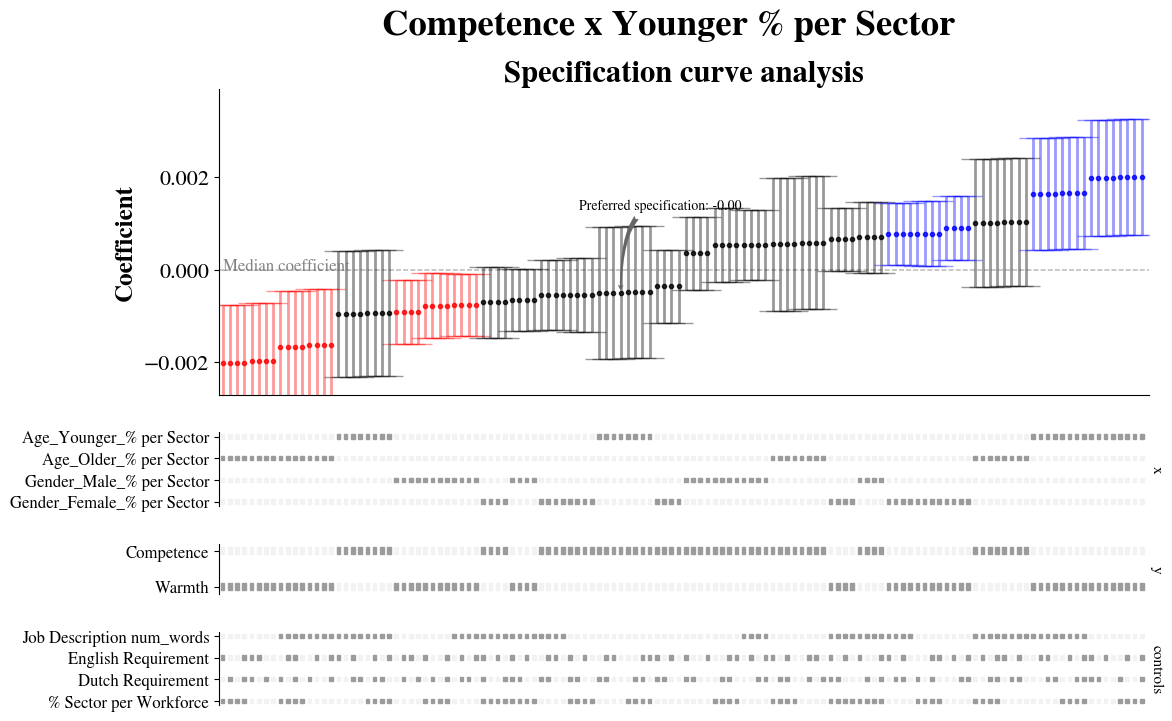

In [28]:
%%time
for (df_name, df), (model_name, model), (iv_type, ivs) in tqdm_product(dataframes.items(), sm_models.items(), ivs_for_spec.items()):

    print(f'{"="*5} {model_name.upper()} REGRESSION SPECIFICATION MODE RESULTS FOR {df_name} USING {iv_type.upper()} {"="*5}')
    print(f'Running specification curve analysis with:\nDEPENDENT VARIABLES = {dvs}\nINDEPENDENT VARIABLES = {ivs}\nCONTROLS = {controls}')

    sc = specy.SpecificationCurve(df=df, y_endog=dvs, x_exog=ivs, controls=controls)
    sc.fit(estimator=model)
    df_results = sc.df_r

    # Plot and save
    for iv, dv in tqdm_product(ivs, dvs):
        print(f'\n{"="*5} RESULTS FOR {iv.title()} ON {dv.title()} {"="*5}\n')

        for image_save_format in tqdm.tqdm(['eps', 'png', 'svg']):
            if iv_type == 'dummy':
                plot_title = f"{dv.title()} x {iv.split('_')[1].title()}-dominated Sectors"
            elif iv_type == 'percentages':
                plot_title = f"{dv.title()} x {' '.join(iv.split('_')[-2:])}"
            save_path = f'{plot_save_path}Specification Curve - {iv} x {dv}.{image_save_format}'
            # Use following if not using forked specification_curve
            # sc.plot(preferred_spec=[iv, dv], save_path=save_path,)
            sc_fig = sc.plot(
                preferred_spec=[iv, dv],
                save_path=save_path,
                show_plot=False,
                return_fig=True,
                plot_title=plot_title
            )

    # Get statsmodels results and save
    ## Get gender only results
    gender_mask = df_results['Specification'].apply(lambda x: any(item for item in iv[:-len(iv)//2] if item in x and len(x) == 2))
    df_results_gender = df_results[gender_mask]
    # Get age only results
    age_mask = df_results['Specification'].apply(lambda x: any(item for item in iv[len(iv)//2:] if item in x and len(x) == 2))
    df_results_age = df_results[age_mask]

    for df in [df_results_gender, df_results_age]:
        for idx, row in df.iterrows():
            for dv_iv in row["Specification"]:
                if dv_iv in ivs_dummy:
                    iv_name = dv_iv
                elif dv_iv in dvs:
                    dv_name = dv_iv
            print('\n')
            print('+'*20)
            print(f'{dv_name} x {iv_name}\n')
            print('+'*20)
            print(f'{row["Results"].summary()}')
            print('-'*20)

            # Save results to file
            df_to_save = pd.DataFrame(csv.reader(row["Results"].summary().as_csv().split('\n'), delimiter=','))
            df_to_save.to_csv(f'{table_save_path}{df_name} {model_name} specification curve {iv_type} - {dv_name} x {iv_name}.csv', index=False)

    # Top 10 significant highest coefficients
    df_coeff_p = df_results.loc[sc.df_r['coeff_pvals'] < 0.05].sort_values(by=['Coefficient'], ascending=False)
    print(f"Top 10 significant coefficients:\n{df_coeff_p[['x_exog', 'y_endog', 'coeff_pvals', 'Coefficient', 'conf_int', 'pvalues']].head(10)}")

    print(f'{"="*5} END OF RESULTS FOR {iv.title()} {"="*5}')


In [29]:
# %%time
# # Logistic Specification Curve Analysis for 0:1 Warmth and Competence x percentage Gender and Age
# for df_name, df in dataframes.items():

#     print(f'{"="*5} RESULTS FOR {df_name} {"="*5}')
#     print(f'Running specification curve analysis with:\nDEPENDENT VARIABLES = {dvs}\nINDEPENDENT VARIABLES = {ivs_dummy}\nCONTROLS = {controls}')

#     sc = specy.SpecificationCurve(df=df, y_endog=dvs, x_exog=ivs_dummy, controls=controls)
#     sc.fit(estimator=sm.Logit)
#     df_results = sc.df_r

#     # Plot and save
#     for iv_dummy, dv in tqdm_product(ivs_dummy, dvs):
#         print(f'{"="*5} RESULTS FOR {iv_dummy.title()} ON {dv.title()} {"="*5}')

#         for image_save_format in tqdm.tqdm(['eps', 'png', 'svg']):
#             save_path = f'{plot_save_path}Specification Curve - {iv_dummy} x {dv}.{image_save_format}'
#             # Use following if not using forked specification_curve
#             # sc.plot(preferred_spec=[iv, dv], save_path=save_path,)
#             sc_fig  = sc.plot(
#                 preferred_spec=[iv_dummy, dv],
#                 save_path=save_path,
#                 show_plot=False,
#                 return_fig=True,
#                 plot_title=f"{dv.title()} x {iv_dummy.split('_')[1].title()}-dominated Sectors"
#             )
#         print(sc_fig)

#     # Get statsmodels results and save
#     ## Get gender only results
#     gender_mask = df_results['Specification'].apply(lambda x: any(item for item in ['Gender_Female_% per Sector', 'Gender_Male_% per Sector'] if item in x and len(x) == 2))
#     df_results_gender = df_results[gender_mask]
#     # Get age only results
#     age_mask = df_results['Specification'].apply(lambda x: any(item for item in ['Age_Older_% per Sector', 'Age_Younger_% per Sector'] if item in x and len(x) == 2))
#     df_results_age = df_results[age_mask]

#     for df in [df_results_gender, df_results_age]:
#         for idx, row in df.iterrows():
#             for dv_iv in row["Specification"]:
#                 if dv_iv in ivs_dummy:
#                     iv_name = dv_iv
#                 elif dv_iv in dvs:
#                     dv_name = dv_iv
#             print('\n')
#             print('+'*20)
#             print(f'{dv_name} x {iv_name}\n')
#             print('+'*20)
#             print(f'{row["Results"].summary()}')
#             print('-'*20)

#             # Save results to file
#             df_to_save = pd.DataFrame(csv.reader(row["Results"].summary().as_csv().split('\n'), delimiter=','))
#             df_to_save.to_csv(f'{table_save_path}logistic specification curve dummy - {dv_name} x {iv_name} {df_name}.csv', index=False)

#     # Top 10 significant highest coefficients
#     df_coeff_p = df_results.loc[sc.df_r['coeff_pvals'] < 0.05].sort_values(by=['Coefficient'], ascending=False)
#     print(f"Top 10 significant coefficients:\n{df_coeff_p[['x_exog', 'y_endog', 'coeff_pvals', 'Coefficient', 'conf_int', 'pvalues']].head(10)}")

#     print(f'{"="*5} END OF RESULTS FOR {iv_dummy.title()} {"="*5}')


In [30]:
# %%time
# # Logistic Specification Curve Analysis for 0:1 Warmth and Competence x percentage Gender and Age
# for df_name, df in dataframes.items():

#     print(f'{"="*5} RESULTS FOR {df_name} {"="*5}')
#     print(f'Running specification curve analysis with:\nDEPENDENT VARIABLES = {dvs}\nINDEPENDENT VARIABLES = {ivs_perc}\nCONTROLS = {controls}')

#     sc = specy.SpecificationCurve(df=df, y_endog=dvs, x_exog=ivs_perc, controls=controls)
#     sc.fit(estimator=sm.Logit)
#     df_results = sc.df_r

#     # Plot and save
#     for iv_perc, dv in tqdm_product(ivs_perc, dvs):
#         print(f'{"="*5} RESULTS FOR {iv_perc.title()} ON {dv.title()} {"="*5}')

#         for image_save_format in tqdm.tqdm(['eps', 'png', 'svg']):
#             save_path = f'{plot_save_path}Specification Curve - {iv_perc} x {dv}.{image_save_format}'
#             # Use following if not using forked specification_curve
#             # sc.plot(preferred_spec=[iv, dv], save_path=save_path,)
#             sc_fig  = sc.plot(
#                 preferred_spec=[iv_perc, dv],
#                 save_path=save_path,
#                 show_plot=False,
#                 return_fig=True,
#                 plot_title=f"{dv.title()} x {' '.join(ivs_perc[0].split('_')[-2:])}"
#             )
#         print(sc_fig)

#     # Get statsmodels results and save
#     ## Get gender only results
#     gender_mask = df_results['Specification'].apply(lambda x: any(item for item in ['Gender_Female_% per Sector', 'Gender_Male_% per Sector'] if item in x and len(x) == 2))
#     df_results_gender = df_results[gender_mask]
#     # Get age only results
#     age_mask = df_results['Specification'].apply(lambda x: any(item for item in ['Age_Older_% per Sector', 'Age_Younger_% per Sector'] if item in x and len(x) == 2))
#     df_results_age = df_results[age_mask]

#     for df in [df_results_gender, df_results_age]:
#         for idx, row in df.iterrows():
#             for dv_iv in row["Specification"]:
#                 if dv_iv in ivs_perc:
#                     iv_name = dv_iv
#                 elif dv_iv in dvs:
#                     dv_name = dv_iv
#             print('\n')
#             print('+'*20)
#             print(f'{dv_name} x {iv_name}\n')
#             print('+'*20)
#             print(f'{row["Results"].summary()}')
#             print('-'*20)

#             # Save results to file
#             df_to_save = pd.DataFrame(csv.reader(row["Results"].summary().as_csv().split('\n'), delimiter=','))
#             df_to_save.to_csv(f'{table_save_path}logistic specification curve percentages - {dv_name} x {iv_name} {df_name}.csv', index=False)

#     # Top 10 significant highest coefficients
#     df_coeff_p = df_results.loc[sc.df_r['coeff_pvals'] < 0.05].sort_values(by=['Coefficient'], ascending=False)
#     print(f"Top 10 significant coefficients:\n{df_coeff_p[['x_exog', 'y_endog', 'coeff_pvals', 'Coefficient', 'conf_int', 'pvalues']].head(10)}")

#     print(f'{"="*5} END OF RESULTS FOR {iv_perc.title()} {"="*5}')
